In [357]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [358]:
# import data set
#data = pd.read_excel("owid-covid-data.xlsx")
country_list = [
    'Spain', 'France', 'Germany', 'Ireland', 'United Kingdom',
    'Italy', 'Belgium', 'Netherlands', 'Switzerland', 'Luxembourg'
]
selected_data = data[data['location'].isin(country_list)]
selected_data['date'] = pd.to_datetime(selected_data['date'])
selected_data.rename(columns={'new_cases_smoothed': 'y'}, inplace=True)
selected_data.head()

/var/folders/n4/3g40sf9n163fj3t1fbrvlns40000gn/T/ipykernel_82036/3416572229.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['date'] = pd.to_datetime(selected_data['date'])
/var/folders/n4/3g40sf9n163fj3t1fbrvlns40000gn/T/ipykernel_82036/3416572229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data.rename(columns={'new_cases_smoothed': 'y'}, inplace=True)


,iso_code,continent,location,date,total_cases,new_cases,y,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
28497,BEL,Europe,Belgium,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN
28498,BEL,Europe,Belgium,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN
28499,BEL,Europe,Belgium,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,-151.3,-6.34,-6.34,-13.086293
28500,BEL,Europe,Belgium,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN
28501,BEL,Europe,Belgium,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN


In [359]:
selected_data.shape

(13570, 67)

We observed zeros in many different countries; this can be attributed to the fact that some countries report weekly instead of daily. Therefore we decided to use new_cases_smoothed as are target variable. 

In [360]:
# drop iso_code and contient as the are not relevant
selected_data = selected_data.drop(['iso_code', 'continent'], axis=1)
# drop total_cases since it is new_cases accumulated
selected_data = selected_data.drop(['new_cases','total_cases', 'total_cases_per_million'], axis=1)
# drop features with >30% missingness
threshold = 0.7 * len(selected_data)
data_clean = selected_data.dropna(thresh=threshold, axis=1)
data_clean.columns

Index(['location', 'date', 'y', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'new_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'new_deaths_smoothed_per_million',
       'reproduction_rate', 'icu_patients', 'icu_patients_per_million',
       'stringency_index', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'population'],
      dtype='object')

In [361]:
missing_count = data_clean['y'].isna().sum()
print(f"Count of missing values: {missing_count}")
missing_indices = data_clean[data_clean['y'].isna()].index.tolist()
print(f"Indices of missing values: {missing_indices}")
missing_dates = data_clean.loc[missing_indices, 'date']
# all missing data comes from the beginning or end of covid, remove
data_clean = data_clean.drop(missing_indices)

Count of missing values: 62
Indices of missing values: [28497, 28498, 28499, 28500, 28501, 103027, 103028, 103029, 103030, 103031, 111167, 111168, 111169, 111170, 111171, 142327, 142328, 142329, 142330, 142331, 146398, 146399, 146400, 146401, 146402, 147749, 147750, 147751, 147752, 147753, 147754, 174892, 174893, 174894, 174895, 174896, 209607, 209608, 209609, 209610, 209611, 288846, 288847, 288848, 288849, 288850, 295631, 295632, 295633, 295634, 295635, 321395, 321396, 321397, 321398, 321399, 322746, 322747, 322748, 322749, 322750, 322751]


In [362]:
# test train split
data_clean = data_clean[data_clean['date'] <= '2023-09-14']
split_date = '2023-09-01'
train = data_clean[data_clean['date'] < split_date]
test = data_clean[data_clean['date'] >= split_date]
# Check the shapes of the train and test sets
print(f"Train Data Shape: {train.shape}")
print(f"Test Data Shape: {test.shape}")

Train Data Shape: (13320, 28)
Test Data Shape: (140, 28)


In [363]:
# remove multicollinear variables; see Prophet_Multiple_Chanel for details
train = train.loc[:, ~train.columns.str.contains('per_hundred|per_million|total|smoothed')]
train.columns

Index(['location', 'date', 'y', 'new_deaths', 'reproduction_rate',
       'icu_patients', 'stringency_index', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'population'],
      dtype='object')

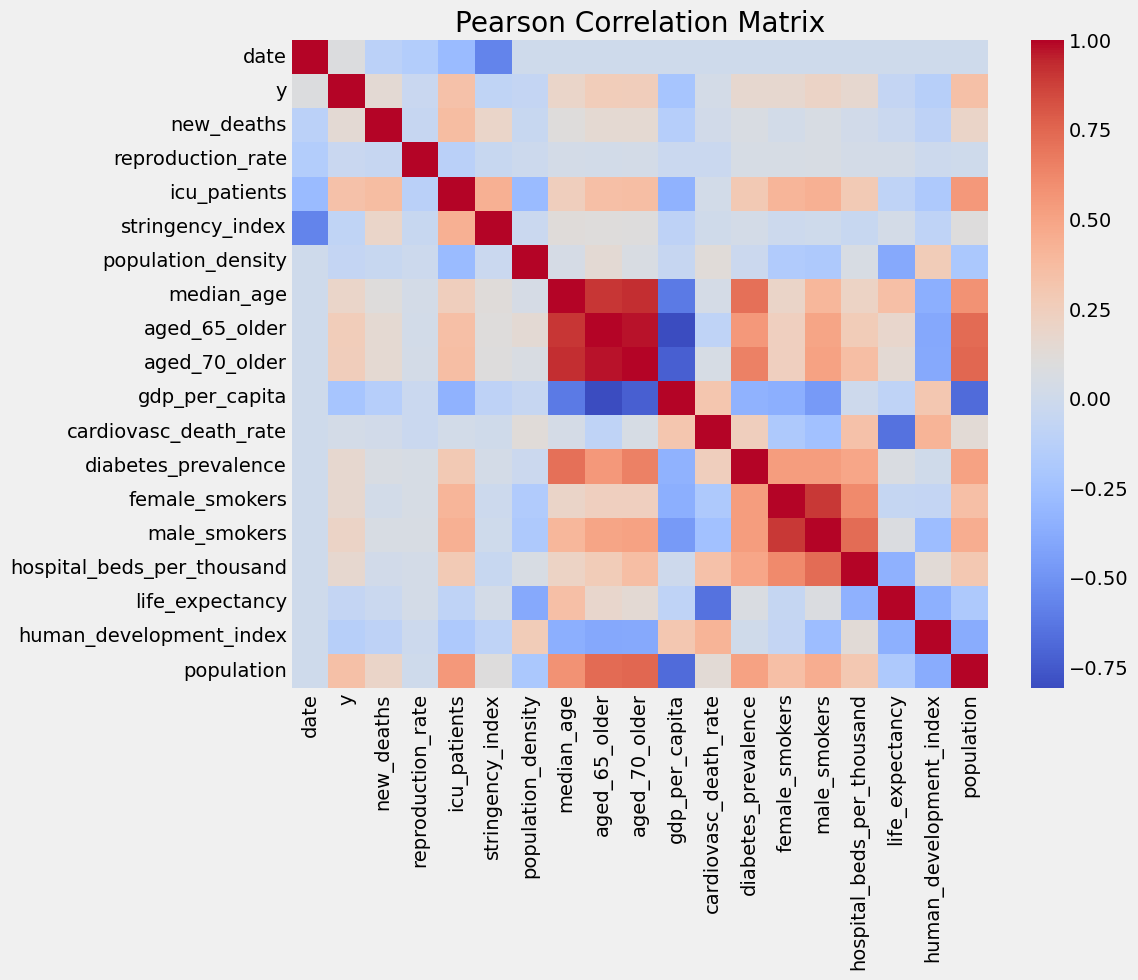

In [364]:
# double check for multicollinearity
train_noloc = train.drop('location', axis=1)
pearson_corr = train_noloc.corr(method='pearson')
plt.figure(figsize=(10,8))
sns.heatmap(pearson_corr,fmt=".2f", cmap='coolwarm')
plt.title('Pearson Correlation Matrix')
plt.show()

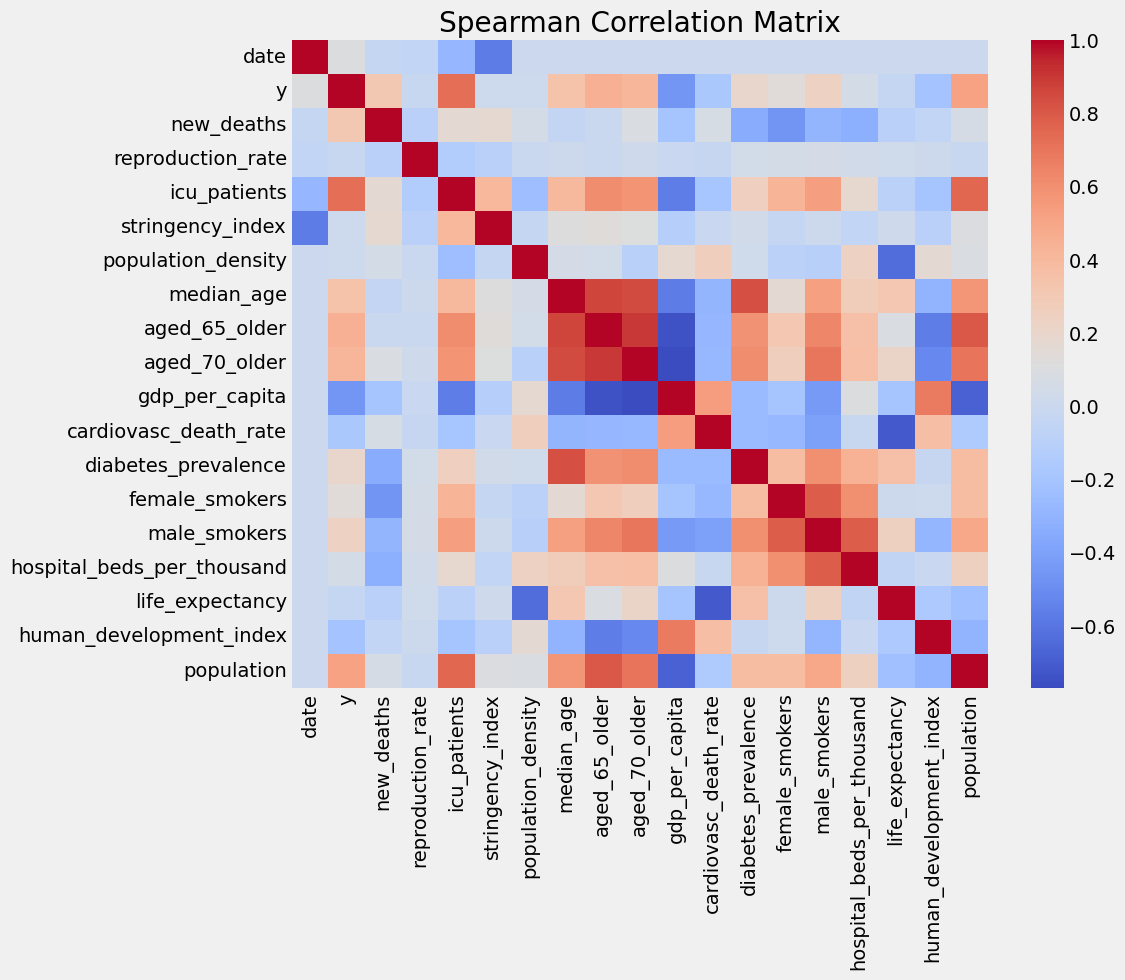

In [365]:
spearman_corr = train_noloc.corr(method='spearman')
plt.figure(figsize=(10,8))
sns.heatmap(spearman_corr, fmt=".2f", cmap='coolwarm')
plt.title('Spearman Correlation Matrix')
plt.show()

In [366]:
# train = train.drop(['median_age', 'aged_65_older','gdp_per_capita'], axis=1)
train.columns

Index(['location', 'date', 'y', 'new_deaths', 'reproduction_rate',
       'icu_patients', 'stringency_index', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'population'],
      dtype='object')

In [367]:
# drop same col for test
test = test.loc[:, ~test.columns.str.contains('per_hundred|per_million|total|smoothed')]
#test = test.drop(['median_age', 'aged_65_older','gdp_per_capita'], axis=1)
test.columns

Index(['location', 'date', 'y', 'new_deaths', 'reproduction_rate',
       'icu_patients', 'stringency_index', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'population'],
      dtype='object')

In [ ]:
# how handle outliers in target 

## Create Time Series Features

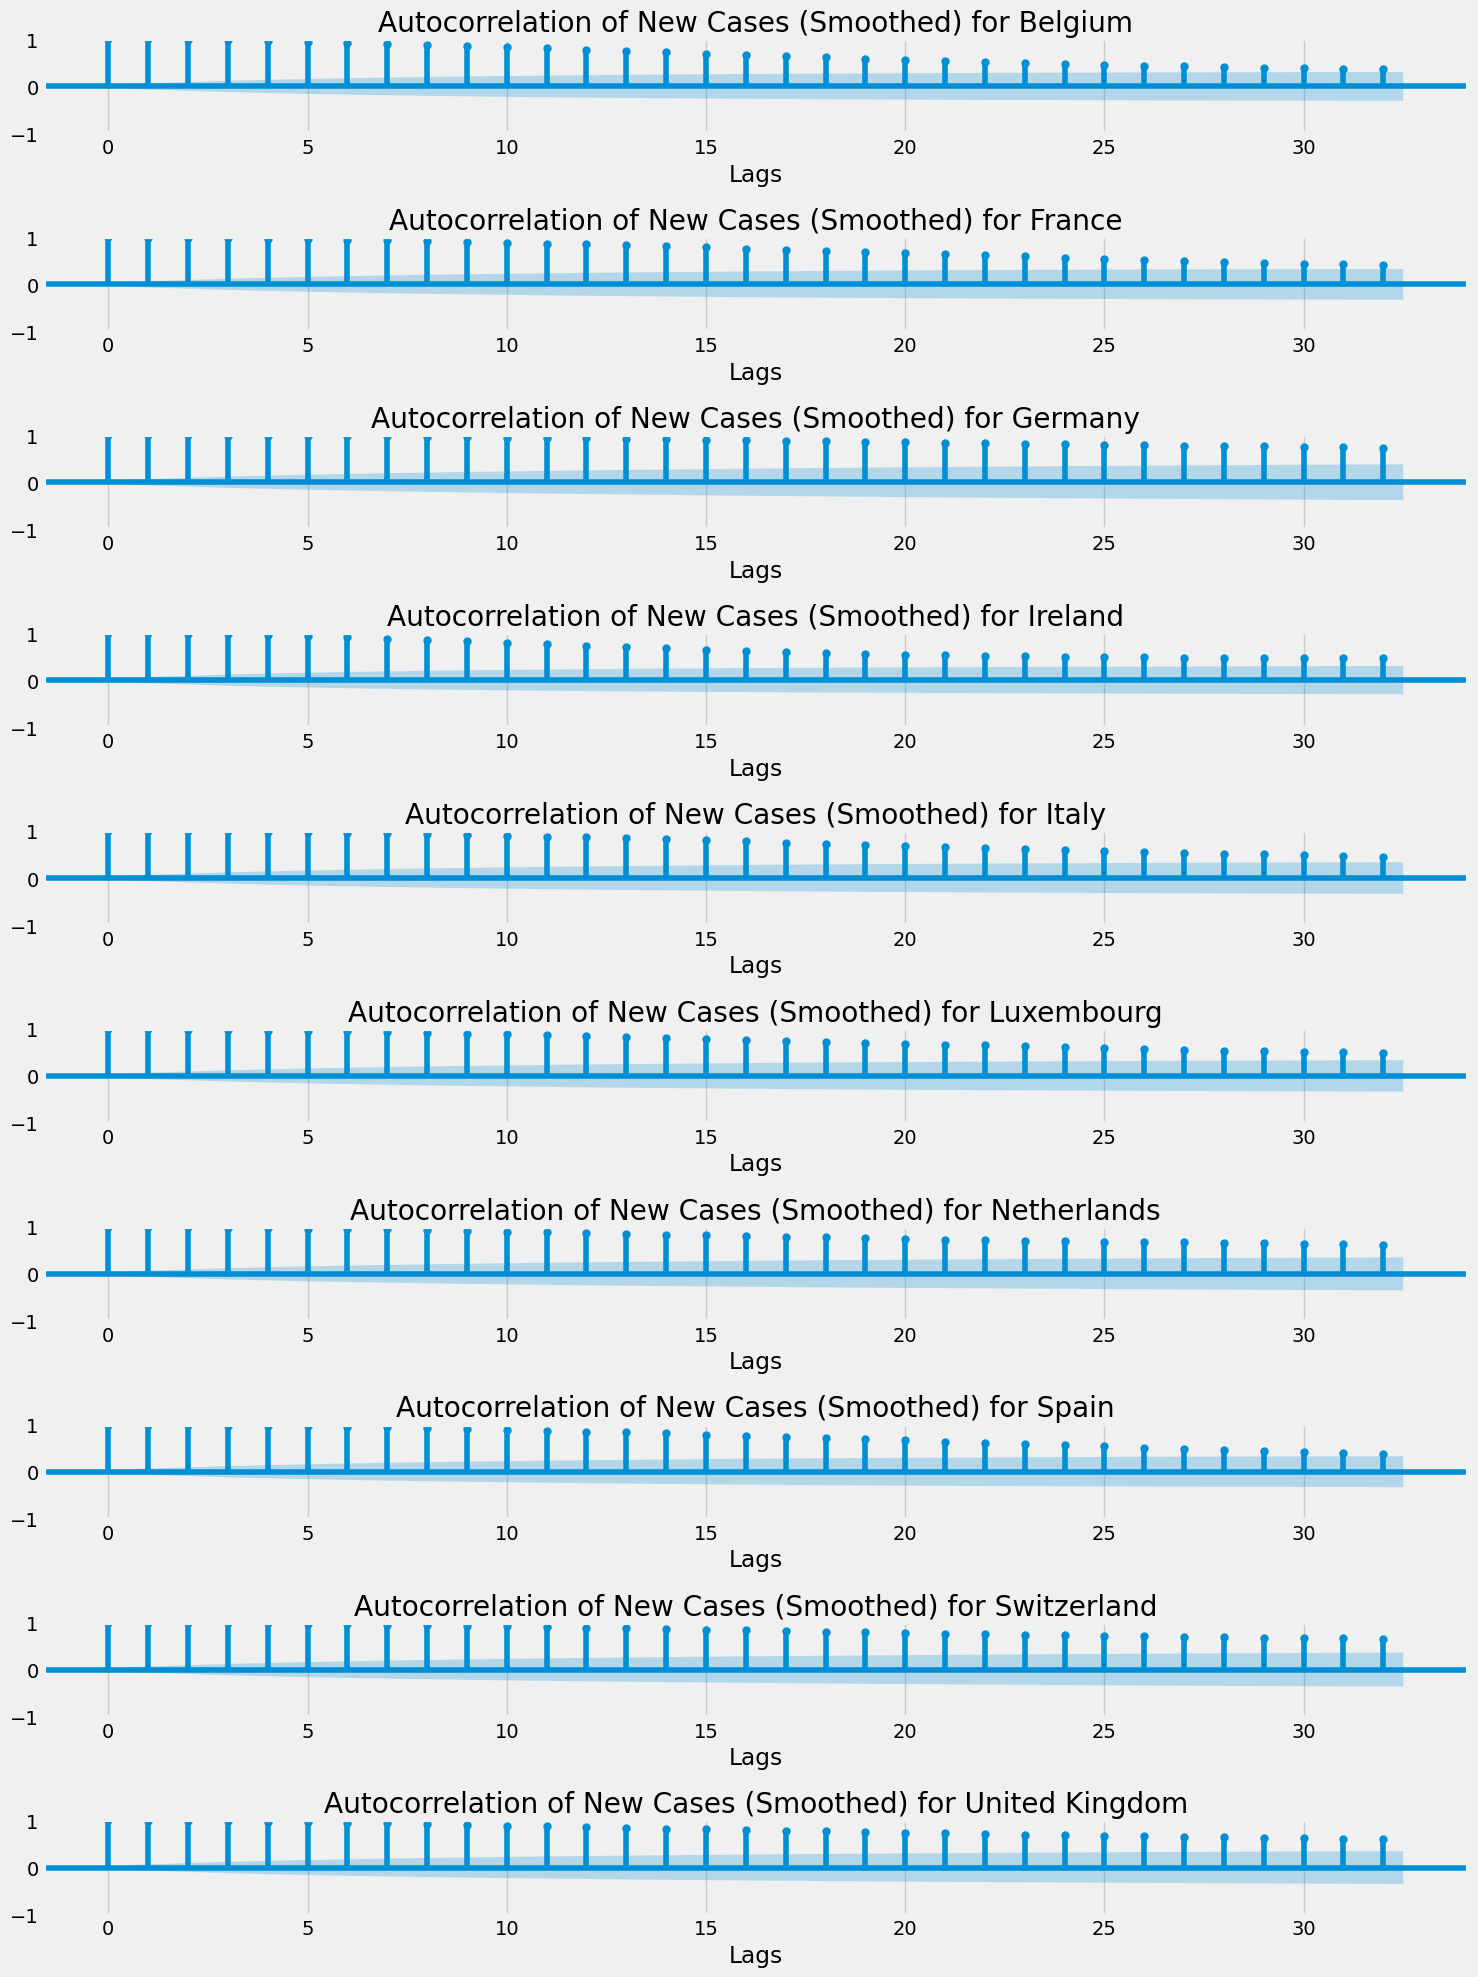

In [368]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

countries = train['location'].unique()

plt.figure(figsize=(15, 20))

for i, country in enumerate(countries, 1):
    plt.subplot(len(countries), 1, i)
    country_data = train[train['location'] == country]['y']
    plot_acf(country_data.dropna(), alpha=0.05, ax=plt.gca())
    plt.title(f'Autocorrelation of New Cases (Smoothed) for {country}')
    plt.xlabel('Lags')

plt.tight_layout()
plt.show()

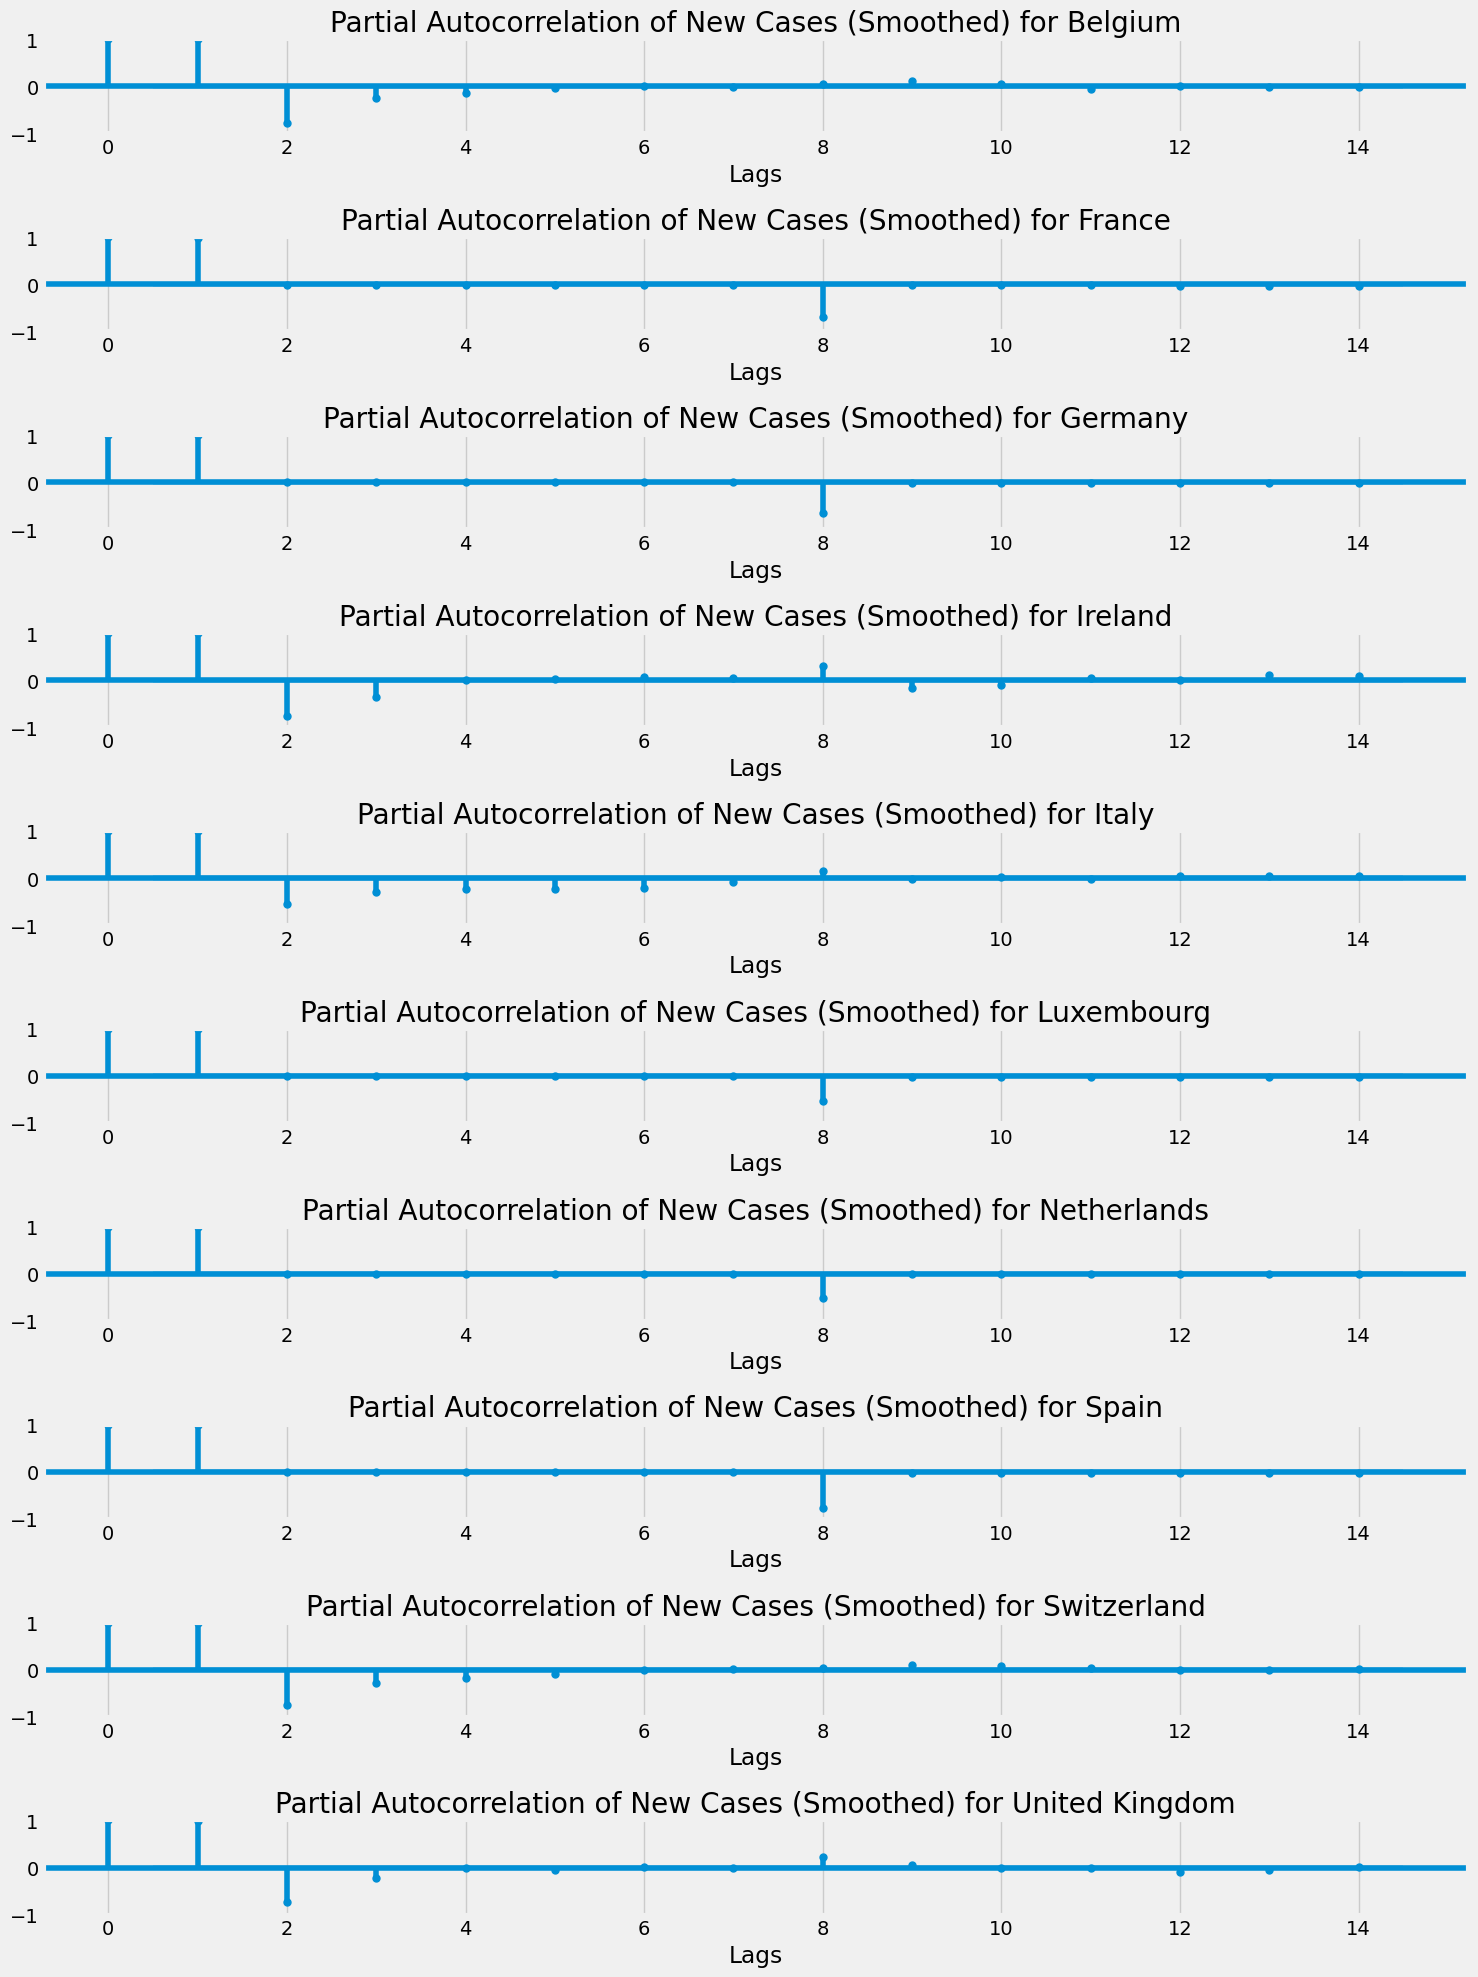

In [369]:
plt.figure(figsize=(15, 20))
for i, country in enumerate(countries, 1):
    plt.subplot(len(countries), 1, i)
    country_data = train[train['location'] == country]['y']
    plot_pacf(country_data, lags=14, ax=plt.gca())
    plt.title(f'Partial Autocorrelation of New Cases (Smoothed) for {country}')
    plt.xlabel('Lags')
plt.tight_layout()
plt.show()

In [370]:
# lagged features with new_cases
for lag in [1, 8]:
    train[f'y_lag{lag}'] = train['y'].shift(lag)
for lag in [1, 8]:
    test[f'y_lag{lag}'] = test['y'].shift(lag)
# rolling window 7-day and 14-day for new_cases
for window in [7, 14]:
    train[f'y_roll_mean{window}'] = train['y'].rolling(window=window).mean()
    train[f'y_roll_std{window}'] = train['y'].rolling(window=window).std()    
for window in [7, 14]:
    test[f'y_roll_mean{window}'] = test['y'].rolling(window=window).mean()
    test[f'y_roll_std{window}'] = test['y'].rolling(window=window).std()

In [371]:
import holidays
import datetime
train['holidays'] = train['date'].apply( lambda x: 'Holiday' if x in holidays.US() 
                                      else 'Holiday' if x + datetime.timedelta(days=1) in holidays.US() else 'Normal day' )
# season
train['season'] = train['date'].apply( lambda x: 'Winter' if x.month == 12 or x.month == 1 or 
                                      x.month == 2 else 'Spring' if  x.month == 3 or 
                                      x.month == 4 or x.month == 5 else 'Summer' if  
                                      x.month == 6 or x.month == 7 or 
                                      x.month == 8 else 'Autumn' if  
                                      x.month == 9 or x.month == 10 or x.month == 11 else '')
# data time features
train.set_index('date', inplace=True)
train['day_of_week'] = train.index.dayofweek
# 0 refers to Monday and 6 to Sunday, we want to tell if the date is weekend or not
train['weekend'] = np.where(train['day_of_week'].isin([5, 6]), 1, 0)
train['month'] = train.index.month
train['year'] = train.index.year
train['quarter'] = train.index.quarter
train['dayofyear'] = train.index.dayofyear
train['dayofmonth'] = train.index.day
train['weekofyear'] = train.index.isocalendar().week.astype(np.int64)

In [372]:
test['holidays'] = test['date'].apply( lambda x: 'Holiday' if x in holidays.US() 
                                      else 'Holiday' if x + datetime.timedelta(days=1) in holidays.US() else 'Normal day' )
# season
test['season'] = test['date'].apply( lambda x: 'Winter' if x.month == 12 or x.month == 1 or 
                                      x.month == 2 else 'Spring' if  x.month == 3 or 
                                      x.month == 4 or x.month == 5 else 'Summer' if  
                                      x.month == 6 or x.month == 7 or 
                                      x.month == 8 else 'Autumn' if  
                                      x.month == 9 or x.month == 10 or x.month == 11 else '')
# data time features
test.set_index('date', inplace=True)
test['day_of_week'] = test.index.dayofweek
# 0 refers to Monday and 6 to Sunday, we want to tell if the date is weekend or not
test['weekend'] = np.where(test['day_of_week'].isin([5, 6]), 1, 0)
test['month'] = test.index.month
test['year'] = test.index.year
test['quarter'] = test.index.quarter
test['dayofyear'] = test.index.dayofyear
test['dayofmonth'] = test.index.day
test['weekofyear'] = test.index.isocalendar().week.astype(np.int64)

In [379]:
# impute outliers in target varible 
from sklearn.preprocessing import RobustScaler
scalers = {}
for location, train_country_data in train.groupby('location'):
    scaler = RobustScaler()
    scaler.fit(train_country_data[['y']])
    train.loc[train['location'] == location, 'y_scaled'] = scaler.transform(train_country_data[['y']])
    # apply to test
    test_country_data = test[test['location'] == location]
    test.loc[test['location'] == location, 'y_scaled'] = scaler.transform(test_country_data[['y']])
    scalers[location] = scaler

In [395]:
# set x_train
x_train = train.drop(columns=['y','y_scaled'])
y_train = train['y']
y_train_scaled = train['y_scaled']
x_test = test.drop(columns=['y','y_scaled'])
y_test = test['y']
y_test_scaled = test['y_scaled']

# x_train['holidays'] = x_train['holidays'].astype('category')
# x_train['season'] = x_train['season'].astype('category')

# x_test['holidays'] = x_test['holidays'].astype('category')
# x_test['season'] = x_test['season'].astype('category')
x_train.columns

Index(['location', 'new_deaths', 'reproduction_rate', 'icu_patients',
       'stringency_index', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'population', 'y_lag1', 'y_lag8',
       'y_roll_mean7', 'y_roll_std7', 'y_roll_mean14', 'y_roll_std14',
       'holidays', 'season', 'day_of_week', 'weekend', 'month', 'year',
       'quarter', 'dayofyear', 'dayofmonth', 'weekofyear'],
      dtype='object')

In [396]:
# encode location since my xgb doesn't support enable_categorical
x_train = pd.get_dummies(x_train, columns=['location'])
x_test = pd.get_dummies(x_test, columns=['location'])

# encode holidays and season
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
x_train['holidays'] = le.fit_transform(x_train['holidays'])
x_test['holidays'] = le.transform(x_test['holidays'])
x_train['season'] = le.fit_transform(x_train['season'])
x_test['season'] = le.transform(x_test['season'])
x_train['season'].head()

date
2020-01-08    3
2020-01-09    3
2020-01-10    3
2020-01-11    3
2020-01-12    3
Name: season, dtype: int64

In [397]:
x_train['holidays'].describe()

count    13320.000000
mean         0.938438
std          0.240367
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: holidays, dtype: float64

In [398]:
x_train.columns

Index(['new_deaths', 'reproduction_rate', 'icu_patients', 'stringency_index',
       'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
       'gdp_per_capita', 'cardiovasc_death_rate', 'diabetes_prevalence',
       'female_smokers', 'male_smokers', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index', 'population', 'y_lag1',
       'y_lag8', 'y_roll_mean7', 'y_roll_std7', 'y_roll_mean14',
       'y_roll_std14', 'holidays', 'season', 'day_of_week', 'weekend', 'month',
       'year', 'quarter', 'dayofyear', 'dayofmonth', 'weekofyear',
       'location_Belgium', 'location_France', 'location_Germany',
       'location_Ireland', 'location_Italy', 'location_Luxembourg',
       'location_Netherlands', 'location_Spain', 'location_Switzerland',
       'location_United Kingdom'],
      dtype='object')

## model dev

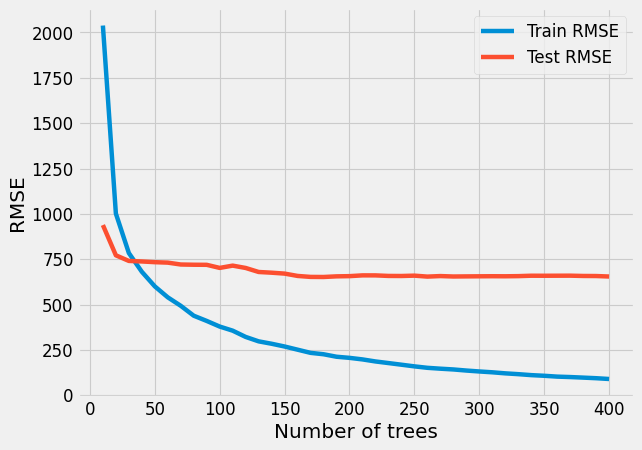

In [392]:
# visualize change in rmse with n_estimators, code for stat303_3 modified
train_rmse = {}
test_rmse = {}

for i in np.linspace(10, 400, 40, dtype=int):
    model = xgb.XGBRegressor(n_estimators=i, random_state=1).fit(x_train, y_train_scaled)
    
    train_pred_scaled = model.predict(x_train)
    train_pred = np.concatenate([scalers[location].inverse_transform(train_pred_scaled[train['location'] == location].reshape(-1, 1)) 
                                 for location in scalers.keys()])
    test_pred_scaled = model.predict(x_test)
    test_pred = np.concatenate([scalers[location].inverse_transform(test_pred_scaled[test['location'] == location].reshape(-1, 1)) 
                                for location in scalers.keys()])

    train_rmse[i] = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse[i] = np.sqrt(mean_squared_error(y_test, test_pred))

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(list(train_rmse.keys()), list(train_rmse.values()), label='Train RMSE')
plt.plot(list(test_rmse.keys()), list(test_rmse.values()), label='Test RMSE')
plt.xlabel('Number of trees')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [408]:
model = xgb.XGBRegressor(enable_categorical = True,
                         learning_rate=0.01, 
                         max_depth=4, 
                         n_estimators=500, 
                         n_jobs=-1, 
                         random_state=0)
model.fit(x_train, y_train_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=-1,
             num_parallel_tree=None, random_state=0, ...)

/var/folders/n4/3g40sf9n163fj3t1fbrvlns40000gn/T/ipykernel_82036/279291169.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_italy['yhat_inversed'] = italy_scaler.inverse_transform(subset_italy['yhat'].values.reshape(-1, 1))


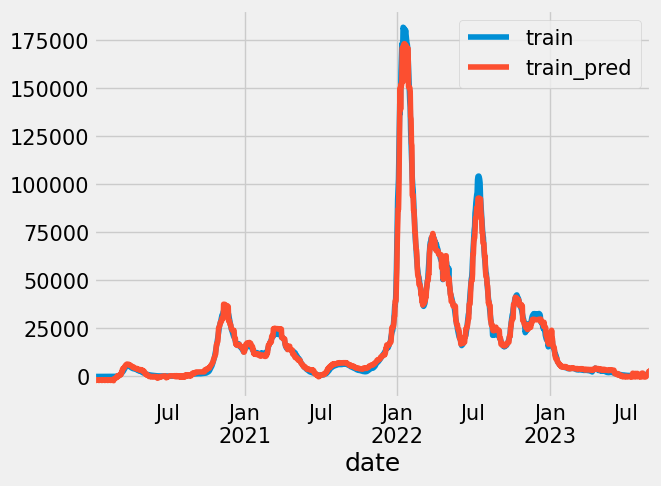

In [409]:
train_pred=pd.DataFrame((model.predict(x_train)), columns=['yhat'], index=train.index)
train_combined = pd.concat([x_train,train['y'],train_pred['yhat']], axis=1)
subset_italy = train_combined[train_combined['location_Italy'] == 1]
italy_scaler = scalers['Italy']
subset_italy['yhat_inversed'] = italy_scaler.inverse_transform(subset_italy['yhat'].values.reshape(-1, 1))
pd.concat([subset_italy['y'], subset_italy['yhat_inversed']], axis=1).plot()
plt.legend(['train', 'train_pred'])

/var/folders/n4/3g40sf9n163fj3t1fbrvlns40000gn/T/ipykernel_82036/3123191161.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_italy['yhat_inversed'] = italy_scaler.inverse_transform(subset_italy['yhat'].values.reshape(-1, 1))


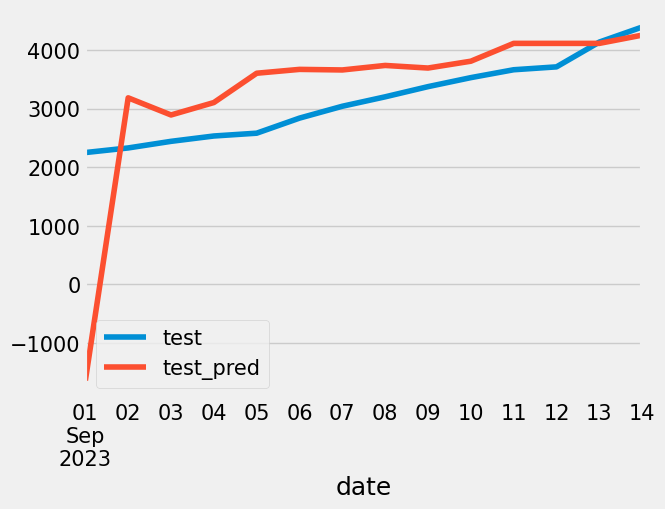

In [410]:
test_pred=pd.DataFrame((model.predict(x_test)), columns=['yhat'], index=test.index)
test_combined = pd.concat([x_test,y_test,test_pred['yhat']], axis=1)
subset_italy = test_combined[test_combined['location_Italy'] == 1]
subset_italy['yhat_inversed'] = italy_scaler.inverse_transform(subset_italy['yhat'].values.reshape(-1, 1))
pd.concat([subset_italy['y'], subset_italy['yhat_inversed']], axis=1).plot()
plt.legend(['test', 'test_pred'])

### without scaler

In [439]:
model2 = xgb.XGBRegressor(enable_categorical = True,
                          learning_rate=0.01, 
                          max_depth=3, 
                          n_estimators=500, 
                          n_jobs=-1, 
                          random_state=0)
model2.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=-1,
             num_parallel_tree=None, random_state=0, ...)

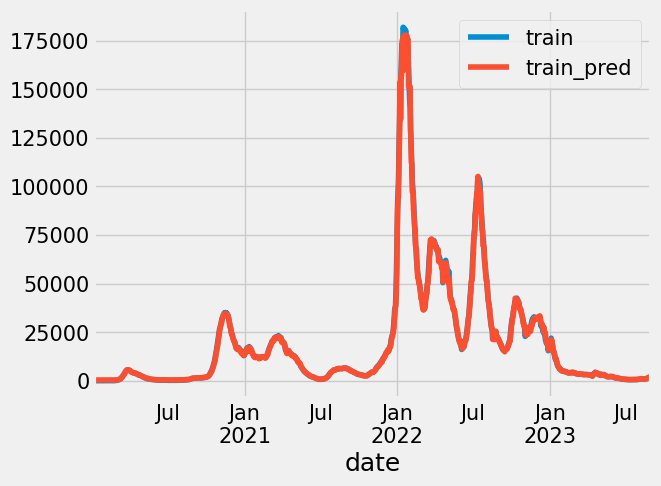

In [440]:
train_pred=pd.DataFrame((model2.predict(x_train)), columns=['yhat'], index=train.index)
train_combined = pd.concat([x_train,y_train,train_pred['yhat']], axis=1)
subset_italy = train_combined[train_combined['location_Italy'] == 1]
pd.concat([subset_italy['y'], subset_italy['yhat']], axis=1).plot()
plt.legend(['train', 'train_pred'])

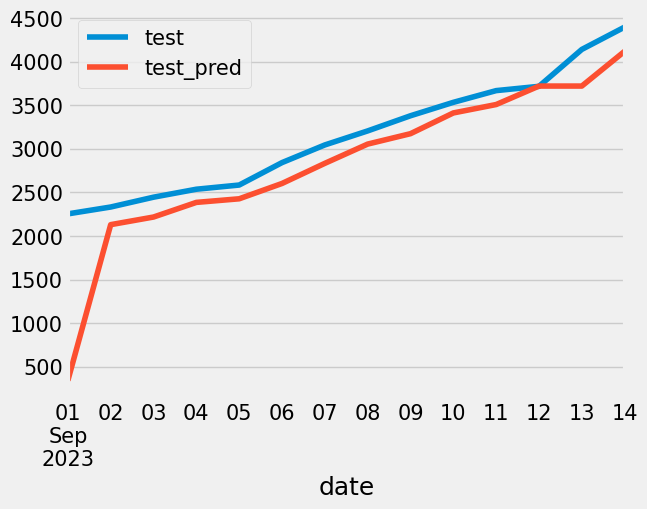

In [441]:
test_pred=pd.DataFrame((model2.predict(x_test)), columns=['yhat'], index=test.index)
test_combined = pd.concat([x_test,y_test,test_pred['yhat']], axis=1)
subset_italy = test_combined[test_combined['location_Italy'] == 1]
pd.concat([subset_italy['y'], subset_italy['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])

In [438]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 2247.7756323512667
Test RMSE: 527.4465229686745


## tuning

In [326]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb

In [356]:
#K-fold cross validation to find optimal parameters for XGBoost
import time
from sklearn.model_selection import KFold, RandomizedSearchCV

# Assuming x_train and y_train are already defined and properly formatted for multivariate analysis
start_time = time.time()

param_grid = {'max_depth': [4, 6, 8],
              'learning_rate': [0.01, 0.05, 0.1],
              'reg_lambda': [0, 1, 10],
            #   'n_estimators': [100, 500, 1000],
              'gamma': [0, 10, 100],
              'subsample': [0.5, 0.75, 1.0],
              'colsample_bytree': [0.5, 0.75, 1.0]}

cv = KFold(n_splits=5, shuffle=True, random_state=1)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=1, n_estimators=200),
                                    param_distributions=param_grid, n_iter=200,
                                    verbose=1, n_jobs=-1, cv=cv,
                                    scoring='neg_root_mean_squared_error') # Setting RMSE as the evaluation metric
optimal_params.fit(x_train, y_train)

print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross-validation RMSE =", optimal_params.best_score_)
print("Time taken = ", round((time.time() - start_time) / 60), " minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Optimal parameter values = {'subsample': 0.75, 'reg_lambda': 10, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 100, 'colsample_bytree': 0.5}
Optimal cross-validation RMSE = -2187.794062652931
Time taken =  1  minutes


In [424]:
model3 = xgb.XGBRegressor(enable_categorical = True,
                          subsample = 0.75,
                          reg_lambda = 10,
                          max_depth = 6, 
                          learning_rate=0.1, 
                          gamma = 100,
                          colsample_bytree = 0.5,
                          n_jobs=-1, 
                          random_state=0)
model3.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=100, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=0, ...)

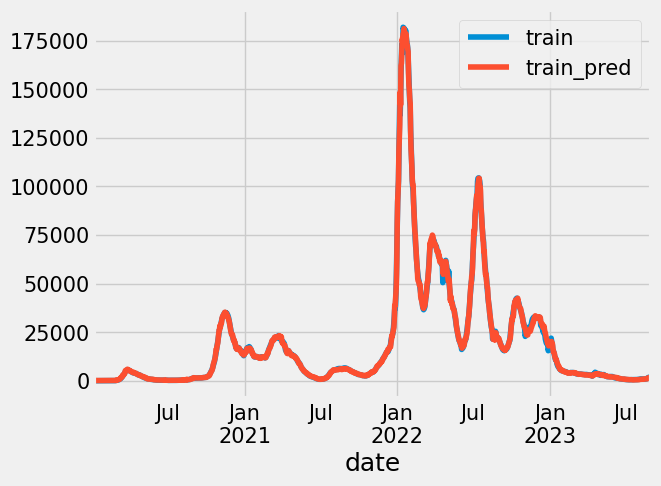

In [425]:
train_pred=pd.DataFrame((model3.predict(x_train)), columns=['yhat'], index=train.index)
train_combined = pd.concat([x_train,y_train,train_pred['yhat']], axis=1)
subset_italy = train_combined[train_combined['location_Italy'] == 1]
pd.concat([subset_italy['y'], subset_italy['yhat']], axis=1).plot()
plt.legend(['train', 'train_pred'])

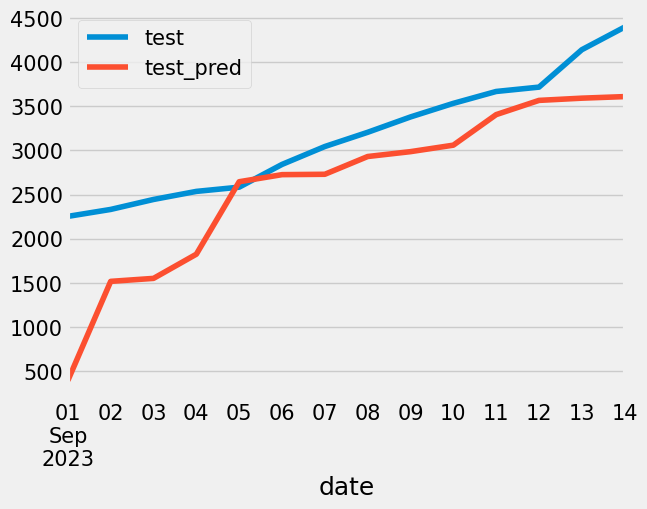

In [426]:
test_pred=pd.DataFrame((model3.predict(x_test)), columns=['yhat'], index=test.index)
test_combined = pd.concat([x_test,y_test,test_pred['yhat']], axis=1)
subset_italy = test_combined[test_combined['location_Italy'] == 1]
pd.concat([subset_italy['y'], subset_italy['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])

In [427]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 890.6400855353431
Test RMSE: 776.3858509917825


## early stopping

In [428]:
model4 = xgb.XGBRegressor(learning_rate=0.3,n_estimators=500, early_stopping_rounds=10,
                       enable_categorical=True)
model4.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)], 
       verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

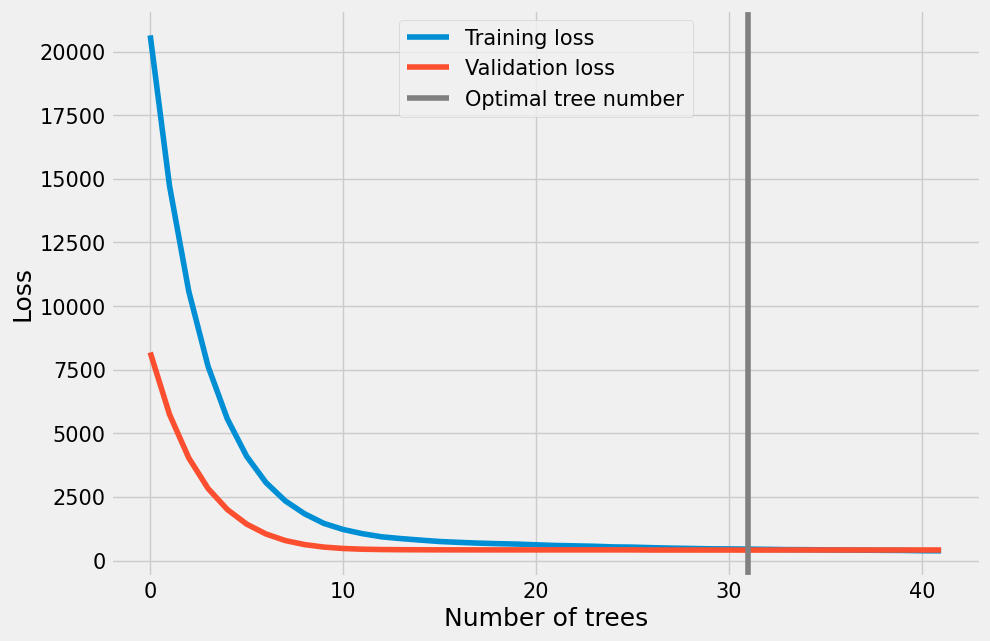

In [429]:
results = model4.evals_result()
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(model4.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [430]:
model4.best_iteration

31

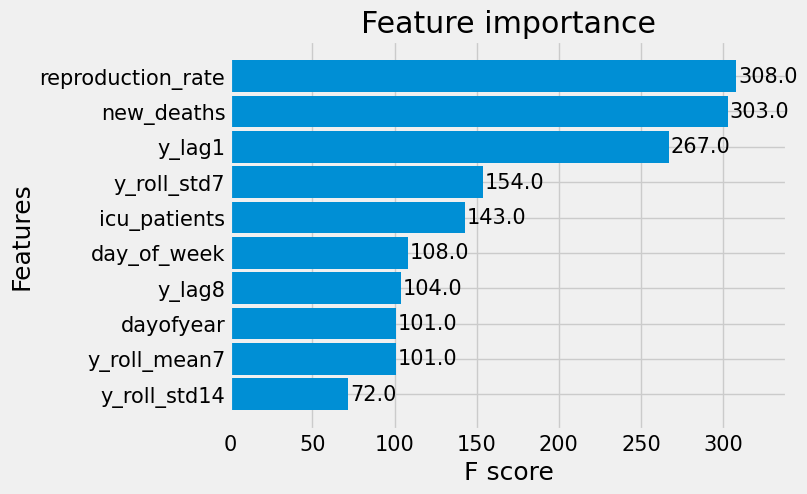

In [431]:
_ = plot_importance(model4, height=0.9 ,max_num_features = 10)

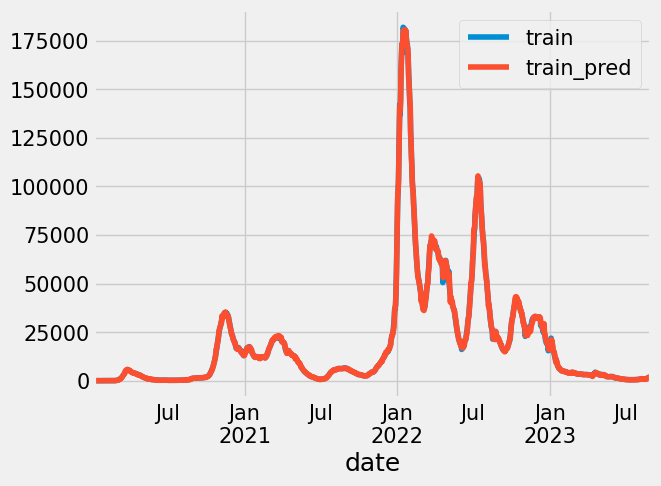

In [432]:
train_pred=pd.DataFrame((model4.predict(x_train)), columns=['yhat'], index=train.index)
train_combined = pd.concat([x_train,y_train,train_pred['yhat']], axis=1)
subset_italy = train_combined[train_combined['location_Italy'] == 1]
pd.concat([subset_italy['y'], subset_italy['yhat']], axis=1).plot()
plt.legend(['train', 'train_pred'])

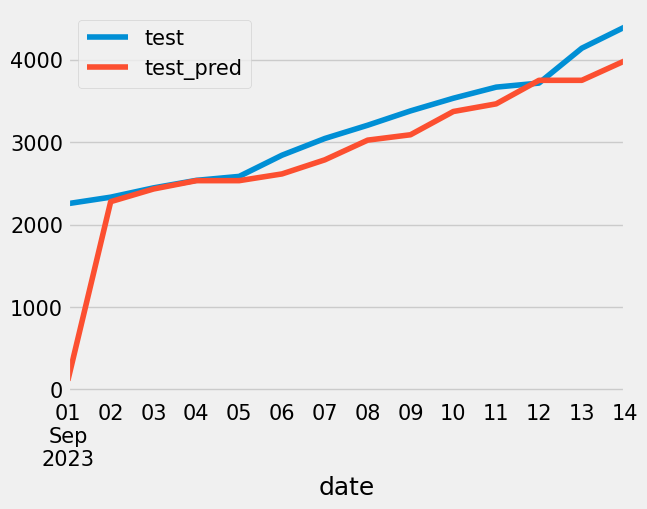

In [433]:
test_pred=pd.DataFrame((model4.predict(x_test)), columns=['yhat'], index=test.index)
test_combined = pd.concat([x_test,y_test,test_pred['yhat']], axis=1)
subset_italy = test_combined[test_combined['location_Italy'] == 1]
pd.concat([subset_italy['y'], subset_italy['yhat']], axis=1).plot()
plt.legend(['test', 'test_pred'])

In [434]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 455.6502447626216
Test RMSE: 418.3073426087695
